# This section is where we import important tools to help us with our code.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import glob
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import seaborn as sns
import scipy.optimize
sns.set()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Below, we are finding the data and sorting it
This means that your csv files should be uploaded into the proper folders in your google drive. You can change the '*' to indicate where names are different for the location of your files

In [ ]:
# locating the data in the google drive
all_files = glob.glob("/*/*/*/*/DMAEMA/*.csv")

# sorting and displaying our files
all_files.sort()
all_files

['/content/drive/MyDrive/Titration_data/DMAEMA/20220617_DMAEMA_1122_008_Tdata1.csv',
 '/content/drive/MyDrive/Titration_data/DMAEMA/20220617_DMAEMA_1122_008_Tdata2.csv']

In [ ]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content': ['.config', 'drive', 'sample_data']


# CSV files are different...
We must 'read' our csv files so that we can access our data on them. This section is reading ALL of the files that you imported and sorted from above. 

In [ ]:
# creating an empty list to add our files once they've been 'read'
list_df = []  
vols = []

for i, f in enumerate(all_files):
  print(i, f)
  
  # using pd.read to read our csv into a dataframe
  df = pd.read_csv(f)
  df["Cycle Number"] = i

  # adding our read files into our empty list in line 2
  list_df.append(df)

  volume_max = df["Volume (mL)"].max()
  vols.append(volume_max)

#list_df

0 /content/drive/MyDrive/Titration_data/DMAEMA/20220617_DMAEMA_1122_008_Tdata1.csv
1 /content/drive/MyDrive/Titration_data/DMAEMA/20220617_DMAEMA_1122_008_Tdata2.csv


# Let's combine all of our files
Since the titrator only dispenses 20mL at a time, we have separate csv files separate only by a difference in volume. The weird thing is that the titrator doesn't add 20mL to the following files after the first cycle. So below we are concatenating them (making the files into one), then adding 20mL after each cycle so that our dataframe ends in the proper volume

Since our titration machine likes to make things difficult by not always dispensing 20 mL of NaOH, here I've created a volume tally to make sure that the ending volume of one csv file is close to the beginning volume of the second csv file 

In [ ]:
adjs = [0]
vol_tally = 0

for volume in vols[:-1]:
  vol_tally += volume
  adjs.append(vol_tally)

In [ ]:
for i, df in enumerate(list_df):
  df["Volume (mL)"] += adjs[i]

In [ ]:
# using the pd.concat function to combine the two files into one
concat_df = pd.concat(list_df, ignore_index=True)

# Adding the derivative column to our dataframe
We have to find the derivative of pH/V, so we do that below and add the new information to a new column in our dataframe. The derivative is important because it locates inflection points from our titration curve. 

In [ ]:
# locating the volumes in our dataframe and creating a variable for them
volumes = concat_df["Volume (mL)"]

# creating a pHs varibale to represent the pH from our data
pHs = concat_df["E(pH)"]

# creating an empty list that begins from 0 to add derivative values to
derivatives_list = [0]

for i in range(1, len(volumes)):
  #print(i)

  # the math to calculate the derivative of pH/Volume
  derivative = (pHs[i] - pHs[i-1]) / (volumes[i] - volumes[i-1])

  # adding our calculation to our list from earlier
  derivatives_list.append(derivative)

# adding a 'derivatives' column to our datafram with our calulcated values
concat_df["dpH/dV"] = derivatives_list

concat_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


,Row Data #,Volume (mL),E(pH),Cycle Number,dpH/dV
0,1,0.000,2.141,0,0.000000
1,2,0.010,2.133,0,-0.800000
2,3,0.020,2.149,0,1.600000
3,4,0.038,2.156,0,0.388889
4,5,0.073,2.171,0,0.428571
...,...,...,...,...,...
229,99,38.224,12.517,1,0.012500
230,100,38.624,12.522,1,0.012500
231,101,39.024,12.526,1,0.010000
232,102,39.424,12.530,1,0.010000


# Now the fun part, graphing!
Now we're going to plot our titration curve and derivative plot. To add a little bit of spice we're going to put them both on one plot...

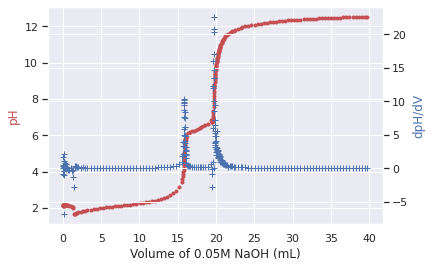

In [ ]:
# creating a plot that can have two y-axis
fig, titration_curve = plt.subplots()

# plotting the two sets of data
derivative_curve = titration_curve.twinx()
titration_curve.plot(volumes, pHs, '.', color='r')
derivative_curve.plot(volumes, derivatives_list, '+', color='b')

# labelling the axes and adding color 
titration_curve.set_xlabel('Volume of 0.05M NaOH (mL)')
titration_curve.set_ylabel('pH', color='r')
derivative_curve.set_ylabel('dpH/dV', color='b');

Woah, that's way too far away. I can't see shit. Let's zoom in on our graphy by editing our minimum x-axis value and maximum x-axis value

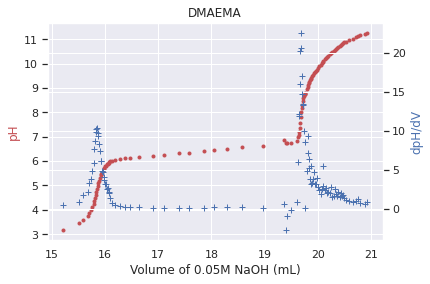

In [ ]:
# trimming to look at just a region
min_x = 15
max_x = 21

trimmed_df = concat_df[(concat_df["Volume (mL)"] > min_x) 
                       & (concat_df["Volume (mL)"] < max_x)]

volumes = trimmed_df["Volume (mL)"]
pHs = trimmed_df["E(pH)"]
derivatives_list = trimmed_df["dpH/dV"]


# creating a plot that can have two y-axis
fig, titration_curve = plt.subplots()

# plotting the two sets of data
derivative_curve = titration_curve.twinx()
titration_curve.plot(volumes, pHs, '.', color='r')
derivative_curve.plot(volumes, derivatives_list, '+', color='b')

# labelling the axes and adding color 
titration_curve.set_title('DMAEMA')
titration_curve.set_xlabel('Volume of 0.05M NaOH (mL)')
titration_curve.set_ylabel('pH', color='r')
derivative_curve.set_ylabel('dpH/dV', color='b');

# Now let's numerically locate our inflection points
Below, I set a region of interest and located the two rows of data for our point of interest

In [ ]:
# need to change these according to location of inflection pt. on plot above!
region1 = [15, 17]
region2 = [19, 20]

# finding the rows of data for the two inflection points
region1_inflection_pt = concat_df[(concat_df["Volume (mL)"]  >= region1[0]) & 
                                  (concat_df["Volume (mL)"] <= region1[1]) &
                                  (concat_df["dpH/dV"] != np.inf) ]
region2_inflection_pt = concat_df[(concat_df["Volume (mL)"]  >= region2[0]) & 
                                  (concat_df["Volume (mL)"] <= region2[1]) &
                                  (concat_df["dpH/dV"] != np.inf) ]

# printing the rows of data for the two inbflection points 
print(region1_inflection_pt.sort_values(by="dpH/dV")[-1:])
print()
print(region2_inflection_pt.sort_values(by="dpH/dV")[-1:])

    Row Data #  Volume (mL)  E(pH)  Cycle Number     dpH/dV
80          81       15.852  4.843             0  10.333333

     Row Data #  Volume (mL)  E(pH)  Cycle Number  dpH/dV
123         124       19.681  7.799             0    22.6


Just to make things more fun, I isolated ONLY the volume at these two points. This is because we care about the location of our inflection points via our volumes. 

In [ ]:
first_infl_pt = region1_inflection_pt.sort_values(by="dpH/dV", ascending=False)[:1]
second_infl_pt = region2_inflection_pt.sort_values(by="dpH/dV", ascending=False)[:1]

# finding the volume of the first inflection pt and the volume of the second inflection pt
region3 = [first_infl_pt["Volume (mL)"].values[0], second_infl_pt["Volume (mL)"].values[0]]

print(region3)

[15.852, 19.681]


# Now we must find the midpoint

In [ ]:
# finding the average of the two inflection points for the midpoint
volume_midpoint = np.mean(region3)

# remember, this is the volume midpoint...we now need to find the pKa..which might not exist in our data
volume_midpoint

17.7665

# Creating a dataframe of the real important info
We create a dataframe of all of our valuable informatiom between our two inflection points. I think that this helps to isolate the really important code to just a few lines. 

In [ ]:
# creating a dataframe of everything between the two inflection points
midpoint_df = concat_df[(concat_df["Volume (mL)"]  >= region3[0]) & (concat_df["Volume (mL)"] <= region3[1])]
midpoint_df

,Row Data #,Volume (mL),E(pH),Cycle Number,dpH/dV
80,81,15.852,4.843,0,10.333333
81,82,15.868,4.993,0,9.375000
82,83,15.878,5.091,0,9.800000
83,84,15.889,5.183,0,8.363636
84,85,15.905,5.303,0,7.500000
85,86,15.924,5.421,0,6.210526
86,87,15.934,5.483,0,6.200000
87,88,15.951,5.566,0,4.882353
88,89,15.961,5.614,0,4.800000
89,90,15.980,5.685,0,3.736842


In [ ]:
#zoomed_midpoint_df = midpoint_df[midpoint_df["Row Data #"][300:350]]
#zoomed_midpoint_df

In [ ]:
for i,vol in enumerate(midpoint_df["Volume (mL)"]):
  if vol > volume_midpoint:
    top_index = i
    bottom_index = top_index -1
    break

In [ ]:
alpha = (midpoint_df['Volume (mL)'] - region3[0]) / (region3[1] - region3[0])
alpha
print(len(alpha))

44


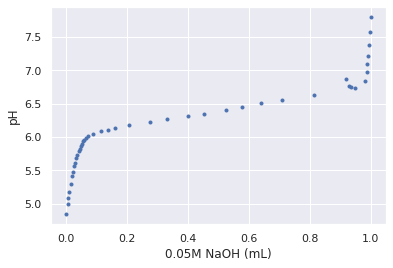

In [ ]:
# plotting the dataframe of everything between the two inflection points
plt.plot(alpha, midpoint_df["E(pH)"], '.')
plt.xlabel("0.05M NaOH (mL)")
plt.ylabel("pH");

# $$pH = pKa - n log((1-a)/a)$$

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


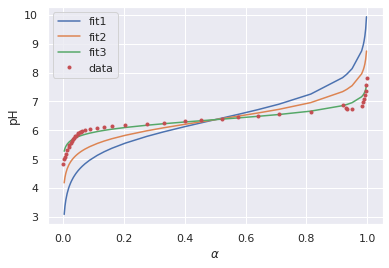

In [ ]:
fit1 = 6.37 - 0.6 * np.log((1 - alpha) / alpha)
fit2 = 6.37 - 0.4 * np.log((1 - alpha) / alpha)
fit3 = 6.37 - 0.2 * np.log((1 - alpha) / alpha)

fits = [fit1, fit2, fit3]

for fit in fits:
  plt.plot(alpha, fit)

plt.plot(alpha, midpoint_df["E(pH)"], '.')
plt.xlabel(r'$\alpha$')
plt.ylabel('pH')

plt.legend(["fit1","fit2","fit3","data"]);

For a given fit, the chi-squared value is defined as:

$$\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}$$

In [ ]:
# using chi_squared to calculate pKa by finding the best fit
def chi_squared(params,data,alpha):

  data = data.values[1:-1]
  alpha = alpha.values[1:-1]

  # setting my parameters
  pKa = params[0]
  n = params[1]
  #print(pKa, n)
  chi_squared = 0

  # fitting the parameters with our Henderson-Hasselbach equation for 
  fit = pKa - n * np.log((1 - alpha) / alpha)

  # using the chi_sqaured equation to fit 
  for i in range(len(data)):

    chi = (data[i] - fit[i])** 2 / fit[i]
    #print(chi)
    chi_squared += chi 
  

  return chi_squared

In [ ]:
chi_squared([6.37,0.2], midpoint_df["E(pH)"], alpha)

0.1342012812060275

In [ ]:
# call to scipy.optimize 
ans = scipy.optimize.minimize(chi_squared, [6.37,0.3], args=(midpoint_df["E(pH)"],alpha), 
                        bounds=[(6,7),(0.2,0.4)])
ans.x
best_pKa = ans.x[0]
best_n = ans.x[1]

best_n

0.2

In [ ]:
best_pKa

6.342849017340716

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


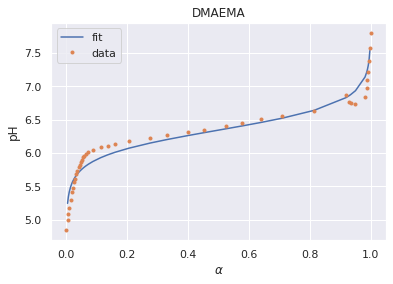

In [ ]:
# plot the best fit
fit = best_pKa - best_n * np.log((1-alpha) / alpha)
plt.plot(alpha, fit)

# plot the data
plt.plot(alpha,midpoint_df["E(pH)"], '.')

# label
plt.title('DMAEMA')
plt.xlabel(r'$\alpha$')
plt.ylabel('pH')
plt.legend(["fit","data"]);